In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [2]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [5]:
print('v2열의 유니크한 값 :',data['v2'].nunique())

v2열의 유니크한 값 : 5169


In [6]:
# v2 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


<Axes: xlabel='v1'>

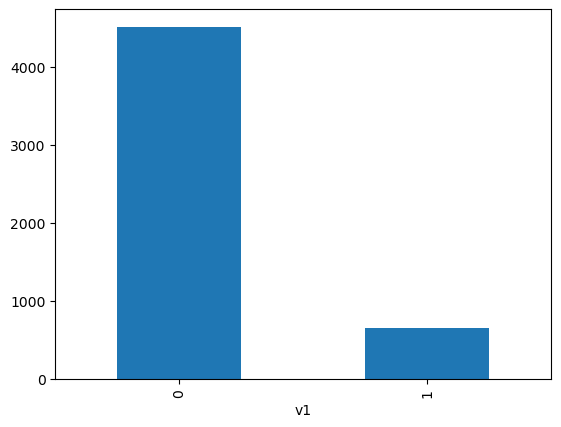

In [7]:
data['v1'].value_counts().plot(kind='bar')

In [8]:
print('정상 메일과 스팸 메일의 개수')
print(data.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 개수
   v1  count
0   0   4516
1   1    653


In [9]:
print(f'정상 메일의 비율 = {round(data["v1"].value_counts()[0]/len(data) * 100,3)}%')
print(f'스팸 메일의 비율 = {round(data["v1"].value_counts()[1]/len(data) * 100,3)}%')

정상 메일의 비율 = 87.367%
스팸 메일의 비율 = 12.633%


In [10]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [12]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
정상 메일 = 87.376%
스팸 메일 = 12.624%


In [13]:
print('--------테스트 데이터의 비율-----------')
print(f'정상 메일 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'스팸 메일 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
정상 메일 = 87.331%
스팸 메일 = 12.669%


In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])

[[102, 1, 210, 230, 3, 17, 39], [1, 59, 8, 427, 17, 5, 137, 2, 2326], [157, 180, 12, 13, 98, 93, 47, 9, 40, 3485, 247, 8, 7, 87, 6, 80, 1312, 5, 3486, 7, 2327, 11, 660, 306, 20, 25, 467, 708, 1028, 203, 129, 193, 800, 2328, 23, 1, 144, 71, 2, 111, 78, 43, 2, 130, 11, 800, 186, 122, 1512], [1, 1154, 13, 104, 292], [222, 622, 857, 540, 623, 22, 23, 83, 10, 47, 6, 257, 32, 6, 26, 64, 936, 407]]


In [15]:
word_to_index = tokenizer.word_index
#print(word_to_index)

In [16]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4337
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.45326684567191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.65745644331875


In [17]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 7822


메일의 최대 길이 : 189
메일의 평균 길이 : 15.754534


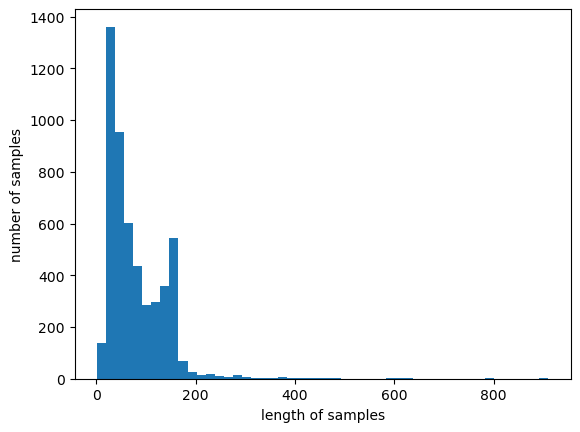

In [18]:
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (4135, 189)


In [20]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - acc: 0.7272 - loss: 0.5544 - val_acc: 0.9649 - val_loss: 0.2353
Epoch 2/4
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9597 - loss: 0.1826 - val_acc: 0.9698 - val_loss: 0.1152
Epoch 3/4
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9812 - loss: 0.0814 - val_acc: 0.9734 - val_loss: 0.0852
Epoch 4/4
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.9897 - loss: 0.0494 - val_acc: 0.9782 - val_loss: 0.0741


In [21]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9828 - loss: 0.0734

 테스트 정확도: 0.9768


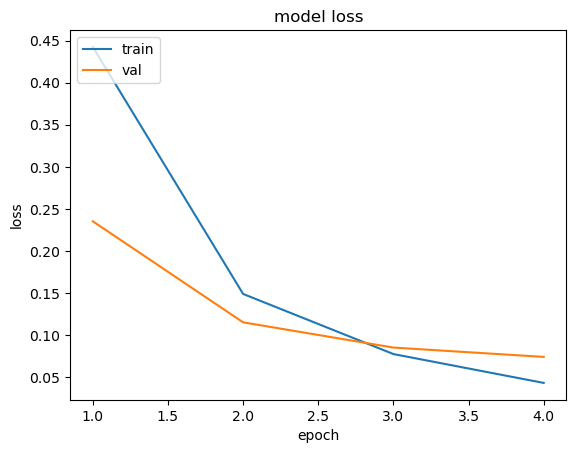

In [22]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()